In [1]:
!pip install opendatasets --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: bigfatgoalie
Your Kaggle Key: ··········


  1%|▏         | 5.00M/395M [00:00<00:07, 51.5MB/s]

100%|██████████| 395M/395M [00:02<00:00, 147MB/s]


In [3]:
import os
DATA_DIR = './animefacedataset'
os.listdir(DATA_DIR)

['images']

In [4]:
os.listdir(DATA_DIR+'/images')[:10]

['51849_2015.jpg',
 '27364_2009.jpg',
 '33887_2011.jpg',
 '44367_2013.jpg',
 '11352_2005.jpg',
 '28587_2010.jpg',
 '12225_2005.jpg',
 '9717_2004.jpg',
 '22276_2008.jpg',
 '14949_2006.jpg']

In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)
]))

In [8]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(image_tensors):
    return image_tensors*stats[1][0] + stats[0][0]

In [11]:
def show_images(images,num=64):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:num]),nrow=8).permute(1,2,0))

In [12]:
def show_batch(dl,num=64):
    for images,_ in dl:
        show_images(images,num)
        break

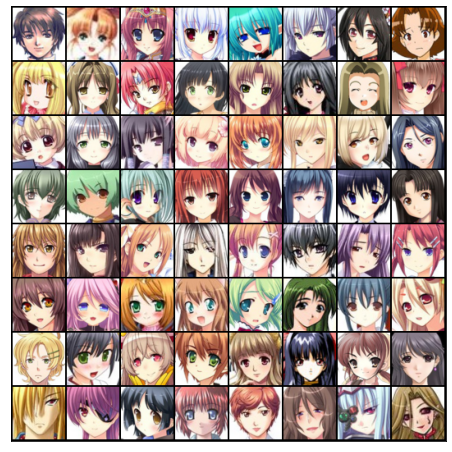

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl,device)

In [17]:
import torch.nn as nn

In [18]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [19]:
discriminator = to_device(discriminator,device)

In [20]:
latent_size = 128

In [21]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


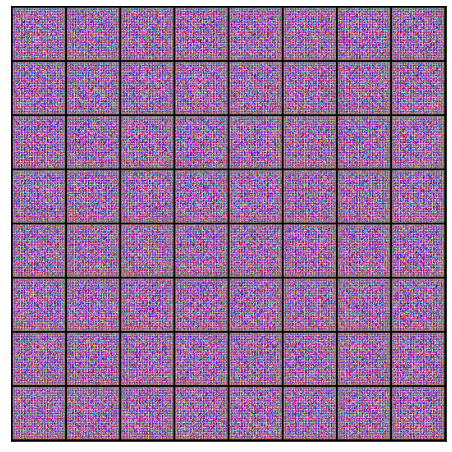

In [22]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [23]:
generator = to_device(generator,device)

In [24]:
loss = nn.BCELoss()

In [36]:
def train_discriminator(real_images,optim_disc):
    optim_disc.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0),1,device=device)
    real_loss = loss(real_preds,real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images = generator(latent)
    fake_targets = torch.zeros(fake_images.shape[0],1,device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = loss(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()

    d_loss = real_loss + fake_loss
    d_loss.backward()
    optim_disc.step()
    return d_loss.item(),real_score,fake_score

In [47]:
def train_generator(optim_gen):
    optim_gen.zero_grad()
    latent = torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images=generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size,1,device=device)
    g_loss = loss(preds,targets)

    g_loss.backward()
    optim_gen.step()

    return g_loss.item()

In [38]:
from torchvision.utils import save_image

In [39]:
sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok=True)

In [40]:
def save_samples(index,latent_tensors,show=True):
    fake_images = generator(latent_tensors)

    fake_fname = f"gen_images-{index}.png"

    save_image( denorm(fake_images), os.path.join(sample_dir,fake_fname), nrow=8)
    print(f'Saving image {fake_fname}')

    if show:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))

In [41]:
first_latent = torch.randn(64, latent_size, 1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving image gen_images-0.png


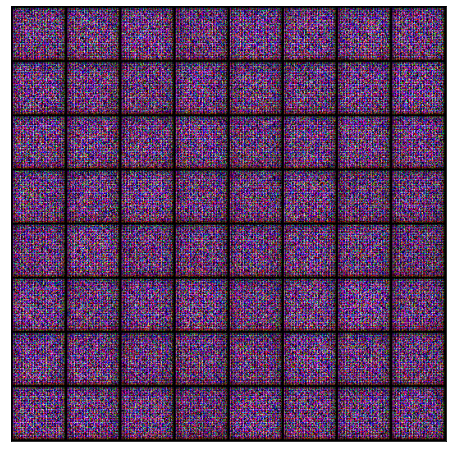

In [42]:
save_samples(0,first_latent)

In [43]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [44]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g, losses_d, real_scores, fake_scores = [],[],[],[]

    optim_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))
    optim_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, optim_d)
            loss_g = train_generator(optim_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print(f"Epoch {epoch+1}/{epochs} loss_g={loss_g} loss_d={loss_d} real_score={real_score} fake_score={fake_score}")
        
        save_samples(epoch+start_idx,first_latent,show=False)
    return losses_g, losses_d, real_scores, fake_scores 

In [45]:
lr = 0.0002
epochs = 25

In [48]:
history = fit(epochs,lr)


Epoch 1/25 loss_g=4.813572883605957 loss_d=0.5910698771476746 real_score=0.9207892417907715 fake_score=0.3578353524208069
Saving image gen_images-1.png



Epoch 2/25 loss_g=4.286884307861328 loss_d=0.3220140337944031 real_score=0.9020498394966125 fake_score=0.17518265545368195
Saving image gen_images-2.png



Epoch 3/25 loss_g=5.026950359344482 loss_d=0.3529694974422455 real_score=0.862450122833252 fake_score=0.15777303278446198
Saving image gen_images-3.png



Epoch 4/25 loss_g=4.983595848083496 loss_d=0.13778705894947052 real_score=0.9204411506652832 fake_score=0.04192611947655678
Saving image gen_images-4.png



Epoch 5/25 loss_g=14.58528995513916 loss_d=1.032464861869812 real_score=0.9926512241363525 fake_score=0.573828935623169
Saving image gen_images-5.png



Epoch 6/25 loss_g=5.395549774169922 loss_d=0.14347940683364868 real_score=0.9863871932029724 fake_score=0.11399883031845093
Saving image gen_images-6.png



Epoch 7/25 loss_g=11.592741012573242 loss_d=0.46042945981025696 real_score=0.9733125567436218 fake_score=0.31384336948394775
Saving image gen_images-7.png



Epoch 8/25 loss_g=5.961505889892578 loss_d=0.20919758081436157 real_score=0.8361586332321167 fake_score=0.0041826218366622925
Saving image gen_images-8.png



Epoch 9/25 loss_g=9.875910758972168 loss_d=0.16641229391098022 real_score=0.8656010031700134 fake_score=0.0012895393883809447
Saving image gen_images-9.png



Epoch 10/25 loss_g=7.1524152755737305 loss_d=0.12862272560596466 real_score=0.9733778834342957 fake_score=0.08932827413082123
Saving image gen_images-10.png



Epoch 11/25 loss_g=6.072610855102539 loss_d=0.06688208132982254 real_score=0.9851633310317993 fake_score=0.04838687181472778
Saving image gen_images-11.png



Epoch 12/25 loss_g=6.2741498947143555 loss_d=0.10232491791248322 real_score=0.9555748105049133 fake_score=0.05012432858347893
Saving image gen_images-12.png



Epoch 13/25 loss_g=4.186635971069336 loss_d=0.23000460863113403 real_score=0.8603931665420532 fake_score=0.03183643892407417
Saving image gen_images-13.png



Epoch 14/25 loss_g=6.232394695281982 loss_d=0.051002439111471176 real_score=0.9722860455513 fake_score=0.019283123314380646
Saving image gen_images-14.png



Epoch 15/25 loss_g=5.7084431648254395 loss_d=0.04977463185787201 real_score=0.9796267151832581 fake_score=0.026358939707279205
Saving image gen_images-15.png



Epoch 16/25 loss_g=5.220682144165039 loss_d=0.4065467119216919 real_score=0.8541030883789062 fake_score=0.14873471856117249
Saving image gen_images-16.png



Epoch 17/25 loss_g=8.520452499389648 loss_d=0.21727675199508667 real_score=0.9904079437255859 fake_score=0.16448301076889038
Saving image gen_images-17.png



Epoch 18/25 loss_g=6.5483527183532715 loss_d=0.12396939098834991 real_score=0.9961248636245728 fake_score=0.10435034334659576
Saving image gen_images-18.png



Epoch 19/25 loss_g=4.692803382873535 loss_d=0.11832220107316971 real_score=0.9272493720054626 fake_score=0.0348609983921051
Saving image gen_images-19.png



Epoch 20/25 loss_g=4.403445243835449 loss_d=0.10372425615787506 real_score=0.938191294670105 fake_score=0.03329324722290039
Saving image gen_images-20.png



Epoch 21/25 loss_g=6.925065994262695 loss_d=0.27625033259391785 real_score=0.8155046105384827 fake_score=0.00020916933135595173
Saving image gen_images-21.png



Epoch 22/25 loss_g=4.055636882781982 loss_d=0.09171964228153229 real_score=0.9479656219482422 fake_score=0.03158547729253769
Saving image gen_images-22.png



Epoch 23/25 loss_g=3.300563335418701 loss_d=0.28686416149139404 real_score=0.8576444387435913 fake_score=0.06757304072380066
Saving image gen_images-23.png



Epoch 24/25 loss_g=5.524142265319824 loss_d=0.1964995414018631 real_score=0.9140165448188782 fake_score=0.07336515933275223
Saving image gen_images-24.png



Epoch 25/25 loss_g=4.8450727462768555 loss_d=0.13792099058628082 real_score=0.9010366201400757 fake_score=0.01763070747256279
Saving image gen_images-25.png


In [50]:
from IPython.display import Image

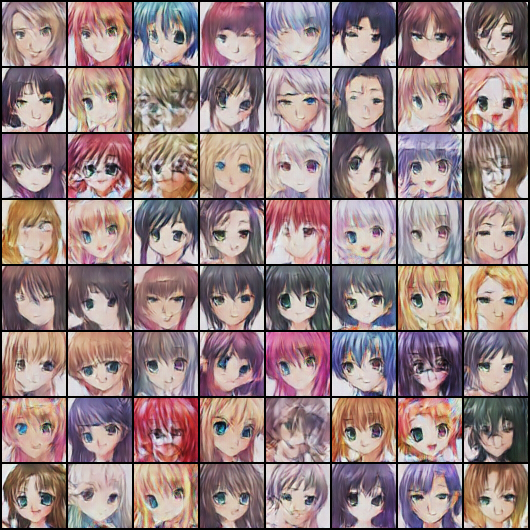

In [51]:
Image('./generated/gen_images-25.png')

In [54]:
import cv2
import os

vid_name = 'test1.avi'

files = [os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'gen' in f]
files.sort()

In [58]:
losses_g, losses_d, real_scores, fake_scores = history

In [56]:
out = cv2.VideoWriter(vid_name,cv2.VideoWriter.fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

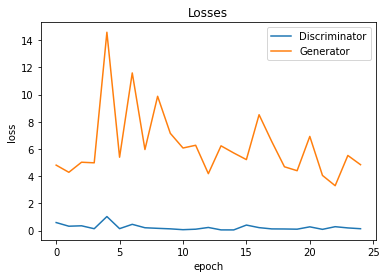

In [59]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

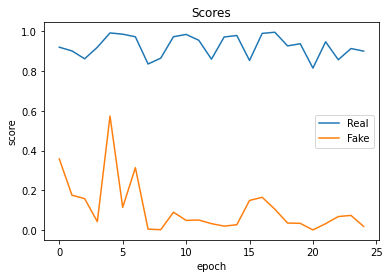

In [60]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');